## 3 - Advancing the general linear model
### Checking assumptions and including interactions

This week we have two broad topics to cover, translating the theoretical discussions to practical applicaton:
- Assumption checking, or ensuring the mathematical assumptions of the GLM are supported
- Interactions, allowing our models to grow in complexity by letting one variable interact with another (or more!) to better predict the outcome.



### Part 1 - Assumption Checks
The most important assumptions of linear models are those of validity and representativeness. But those are things that should be checked long before a model is applied to the data. Here, we'll focus on checking the mathematical components of the model.

As always we'll import the needed packages before we start.

In [1]:
# Import most of what we need
import pandas as pd # dataframes
import seaborn as sns # plots
import statsmodels.formula.api as smf # stats, note the traditional alias
import scipy.stats as st

# Set the style for plots
sns.set_style('whitegrid') # a different theme!
sns.set_context('talk')

### Checking the normality of residuals
Lets examine how to query the least-important assumption first. Checking whether the residuals of a model is very easy via a combination of plotting and tests. When you fit a regression model with `statsmodels`, the residuals are stored for you in the `.resid` attribute of the model.

We will stick with the `tips` dataset to demonstrate, fitting a simple model predicting the tip amount from the cost of the total bill:

In [2]:
# Load dataset
tips = sns.load_dataset('tips')

# Fit the model
model = smf.ols('tip ~ total_bill', data=tips).fit()

We can now access the `.resid` of our model, which contains all the residuals (observed datapoint - predicted datapoint). If we pass this to a `seaborn` function called `histplot`, we obtain a histogram and can add a density plot over it too in a simple command:

<Axes: ylabel='Count'>

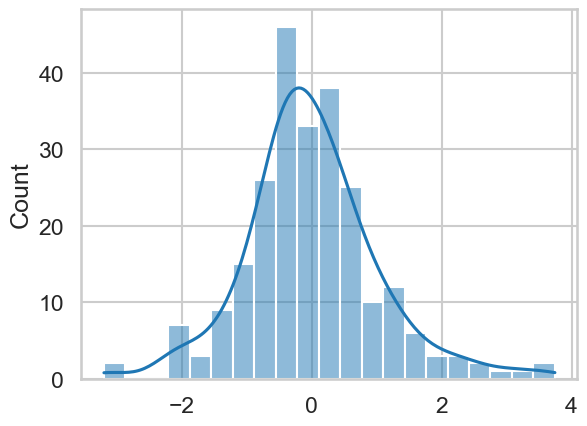

In [3]:
# Histplot
sns.histplot(model.resid, kde=True)

This looks pretty much like a normal distribution. You can go one step further and conduct a statistical test called the *Shapiro-Wilk* test, which tests whether a sample of data comes from a normal distribution. A significant result from this would indicate that the sample differs from a normal distribution. We can import it from a package called `scipy.stats` and run it on the residuals:

In [4]:
# Import 
from scipy.stats import shapiro
shapiro(model.resid)

ShapiroResult(statistic=0.9672804064016676, pvalue=2.171379854243929e-05)

This test is significant, indicating this distribution of residuals is *unlikely to come from a normal distribution*. This is nothing to worry about. The simple truth is that real data does not conform perfectly to these reference distributions, but being able to check is a useful skill. Rarely will violation of this assumption cause issues with inference, and obviously severe issues should appear in the plots if they exist.

Lets see what happens when it goes wrong. We'll use the `affairs` dataset, and see if we can predict the number of affairs from years married.

<Axes: ylabel='Count'>

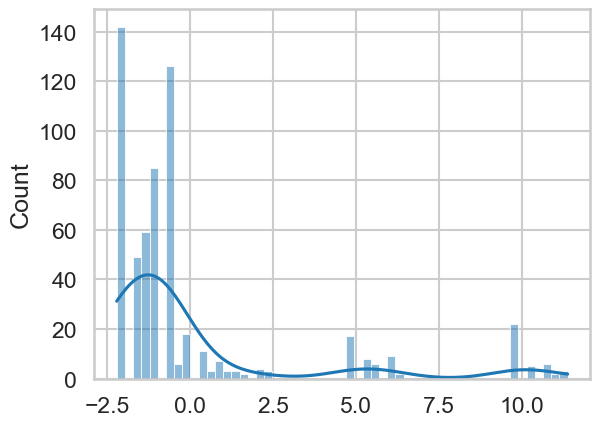

In [5]:
# First read in the data
affairs = pd.read_csv('https://vincentarelbundock.github.io/Rdatasets/csv/AER/Affairs.csv')

# Fit the simple model
model2 = smf.ols('affairs ~ yearsmarried', data=affairs).fit()

# Plot the residuals
sns.histplot(model2.resid, kde=True)

This is clearly off, and should give you pause. Particularly it suggests that a GLM is not a good model for this dependent variable - and that's OK. You can still make predictions and draw conclusions, but with the caveat that your model makes big errors in certain places!

### Checking for homoscedasticity
We next consider how to examine whether the model exhibits equal variance of errors; that is, the magnitude of the errors is the same across the range of the X axis.

We do this graphically, by plotting the *predicted* values against the *residuals*. Like the residuals, `statsmodels` stores the predicted values in the `.fittedvalues` attribute.

Ideally we hope to see a simple random scatter, suggesting no association at all. If there was a pattern, it might suggest that, for example, that when the model makes a prediction that is large, the residuals get larger - the error is not constant!

Let us take a look at these plots for the `tip` model, where we predicted tip amount from the total bill, stored in `model`:

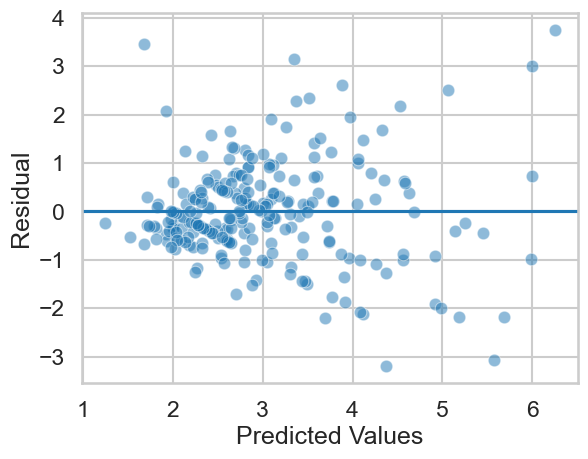

In [6]:
# Homoscedasticity plot
axis = sns.scatterplot(x=model.fittedvalues, 
                       y=model.resid, alpha=.5) # scatter is easy
axis.set(xlabel='Predicted Values', ylabel='Residual') # Renaming 
axis.axhline(0) # Adding a horizontal line at zero

This looks mostly OK, albeit with a little bit of a 'fanning' - as the predicted tip amount increases, the errors get larger. This indicates we could improve our model with more predictors, interactions, and so on. On the other hand, we can accept that there is simply less data in the higher tip ranges - about 11% of the tips are greater than $5. If we wanted more accurate predictions on bigger tips, we'd need more data! 

### Checking for linearity/additivity
This assumption can be checked in two ways. One is by plotting the predictors against the dependent variable. You should hope to see straightforward linear relationships for a GLM to be effective.

We can use `seaborn` and its `pairplot` function to build a grid of plots that show how each variable is related to others. If we were predicting tip amount from party size and total bill, we'd want to see if party size and total bill were *linearly* associated with tip, which we could assess like so:

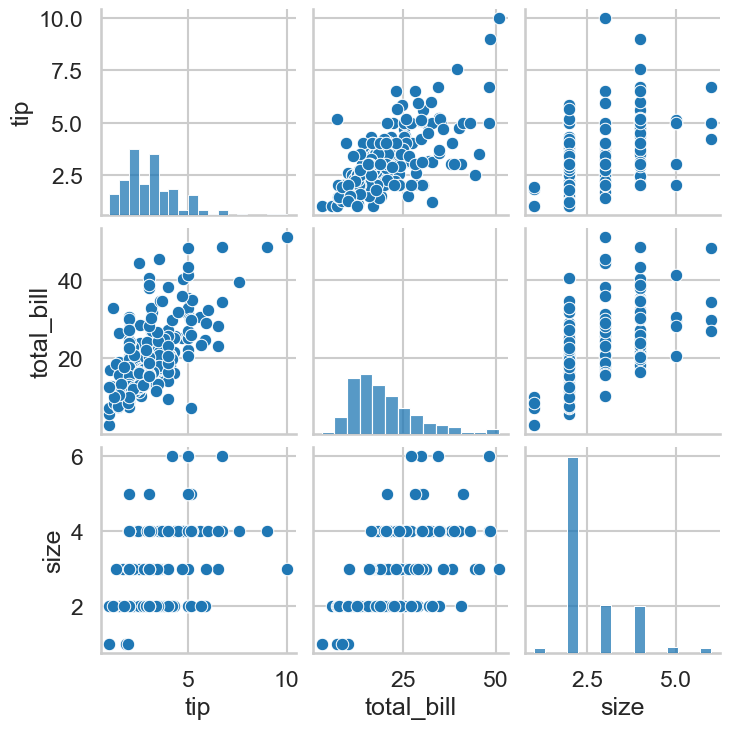

In [7]:
# Select variables
variables = tips[['tip', 'total_bill', 'size']]

# Pairplot
sns.pairplot(variables)

This looks good! Similarly, you can assess the assumption of linearity by once again looking at the predicted vs residual plots. An inherently non-linear relationship will appear there, as the model tries to give linear predictions to something non-linear, showing wildly divergent residuals. A simulated example would look like this:

In [8]:
import numpy as np
rng = np.random.default_rng(42)

N = 200
X = np.sort(rng.normal(5, 10, size=N))
y = 1 + (X * 1.2) + (X**2 * 2.4) + rng.normal(0, 2, size=N)

# Linear combination
d = pd.DataFrame({'X': X, 'y': y})
m = smf.ols('y ~ X', data=d).fit()

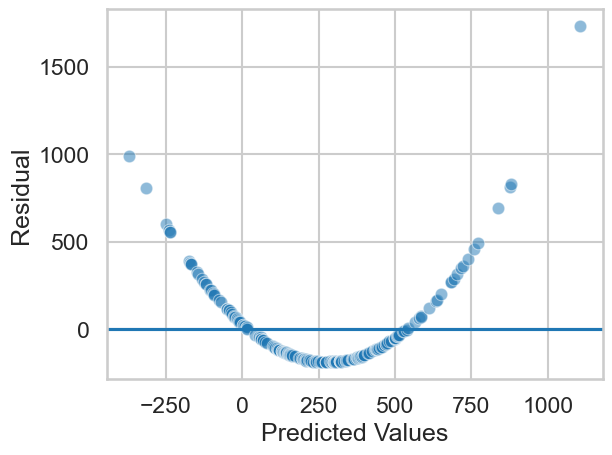

In [9]:
# Plot
axis = sns.scatterplot(x=m.fittedvalues, y=m.resid, alpha=.5)
axis.set(xlabel='Predicted Values', ylabel='Residual') # Renaming 
axis.axhline(0) # Adding a horizontal line at zero

Clearly the models linear predictions are severely off for this nonlinear association. If you see this, *you can still use linear regression*, but you will need to include some extra terms we won't cover in this course. The GLM is very powerful!

### Part 2 - Interactions
Interactions allow us to flexibly alter our model, so that the influence of one predictor on the outcome can depend on the level of another. You are most likely familiar with interactions from ANOVA, where the difference between levels of one factor can vary depending on the level of other factors.

Setting up an interaction is very straightforward with `statsmodels`. You can introduce one by using `:` between variables in a formula string, which will allow them to interact. 

First, let us see how this works with the `tips` dataset. We will fit a model that predicts the tip amount from the total bill value (`total_bill`) and the day (`day`), and then another that allows them to interact. The differences in output will highlight why relying on coefficients becomes very difficult when interpreting models beyond simple ones.

In [10]:
# Fit a non interaction and examine model output
no_interaction = smf.ols('tip ~ total_bill + day', data=tips).fit()
no_interaction.summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    tip   R-squared:                       0.459
Model:                            OLS   Adj. R-squared:                  0.450
No. Observations:                 244   F-statistic:                     50.67
Covariance Type:            nonrobust   Prob (F-statistic):           7.52e-31
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9205      0.186      4.943      0.000       0.554       1.287
day[T.Fri]     0.0189      0.269      0.070      0.944      -0.511       0.549
day[T.Sat]    -0.0671      0.172     -0.391      0.697      -0.406       0.271
day[T.Sun]     0.0935      0.178      0.526      0.599      -0.257       0.444
total_bill     0.1047      0.008     13.915      0.000       0.090       0.119
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

And one with an interaction:

In [11]:
# Interaction
interaction = smf.ols('tip ~ total_bill + day + total_bill:day',
                      data=tips).fit()
interaction.summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    tip   R-squared:                       0.483
Model:                            OLS   Adj. R-squared:                  0.468
No. Observations:                 244   F-statistic:                     31.49
Covariance Type:            nonrobust   Prob (F-statistic):           1.24e-30
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.5122      0.317      1.616      0.107      -0.112       1.137
day[T.Fri]                0.5966      0.629      0.948      0.344      -0.643       1.836
day[T.Sat]                0.0064      0.409      0.016      0.988      -0.799       0.812
day[T.Sun]                1.2409      0.440      2.819      0.005       0.374       2.108
total_bill                0.1278      0.016      7.795      0.000       0.095       0.160
total_bill:day[T.Fri]    -0.0330      0.033     -0.999      0.319      -0.098       0.032
total_bill:day[T.Sat]    -0.0067      0.020     -0.335      0.738      -0.046       0.033
total_bill:day[T.Sun]    -0.0576      0.021     -2.737      0.007      -0.099      -0.016
=========================================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The coefficients are hard to interpret. This is a categorical (day) by continuous (total bill) interaction, and already we're struggling!
- The coefficients representing Friday, Saturday, and Sunday represent the differences between those days and Thursday (the intercept)
- The coefficient for total bill represents the association between total bill and tip, when all other coefficients are zero (so actually tips on Thursday!)
- The coefficients with the interaction operator (`:`) indicates differences between the total bill and tip association on Thursday with each day.

If you have more variables, you can forget trying to interpret these - and even in their current form, explaining them to others is hard!

We are often concerned about whether there 'is' an interaction between variables. The coefficients above do not speak to that, as they represent the individual components that make up the interaction effect and are hard to interpret. 

I don't advocate this approach, since if we think there is an interaction, we include it in the model, and we progress to assessing our predictions from there. But sometimes you will want to assess whether the inclusion of the interaction *significantly improves the model* - that is, it increases the $R^2$. You can do that like so:

- Fit a model without the interaction.
- Fit a model with the inteaction.
- Let an *F*-test determine whether the model with the interaction has a higher $R^2$ then the one without.

$R^2$ has lots of issues, but to do this, you can use the following code:

In [12]:
# A test of whether the interaction significantly improves R2
interaction.compare_f_test(no_interaction)

(3.659151080807126, 0.013142903887848566, 3.0)

Each model has a `.compare_f_test` method. If you give it the model without the interaction, it will tell you the answer - an F value, a p-value, and the degrees of freedom. Here, this suggests a significant improvement with the interaction.

Another useful apporach is to compare the RMSE, or the magnitude of errors in prediction, of both models:

In [13]:
# Import RMSE
import statsmodels.tools.eval_measures as measures

# RMSE of no interaction
print('No interaction RMSE:', 
      measures.rmse(no_interaction.fittedvalues, tips['tip']),
      'Interaction RMSE:',
      measures.rmse(interaction.fittedvalues, tips['tip'])
     )

No interaction RMSE: 1.0157339160931298 Interaction RMSE: 0.9929040944116752


A reduction, but not by much! In terms of accuracy, this about 2 cents (remember that the amount of tips is in terms of dollars). This is why we should be wary of significance tests and instead rely on careful evaluation of metrics.

Finally, it is instructive to see what the model 'sees' when fitting an interaction. An interaction can be thought of as fitting separate regression lines for one variable at different levels of another variable, which is clearer with a graph:

In [14]:
# Hide this cell
import marginaleffects as me
predmat_no = me.avg_predictions(no_interaction, by=['total_bill', 'day'])
predmat_ye = me.avg_predictions(interaction, by=['total_bill', 'day'])

predmat = pd.concat([predmat_no.to_pandas().assign(interaction='Absent'),
                     predmat_ye.to_pandas().assign(interaction='Present')
                    ])

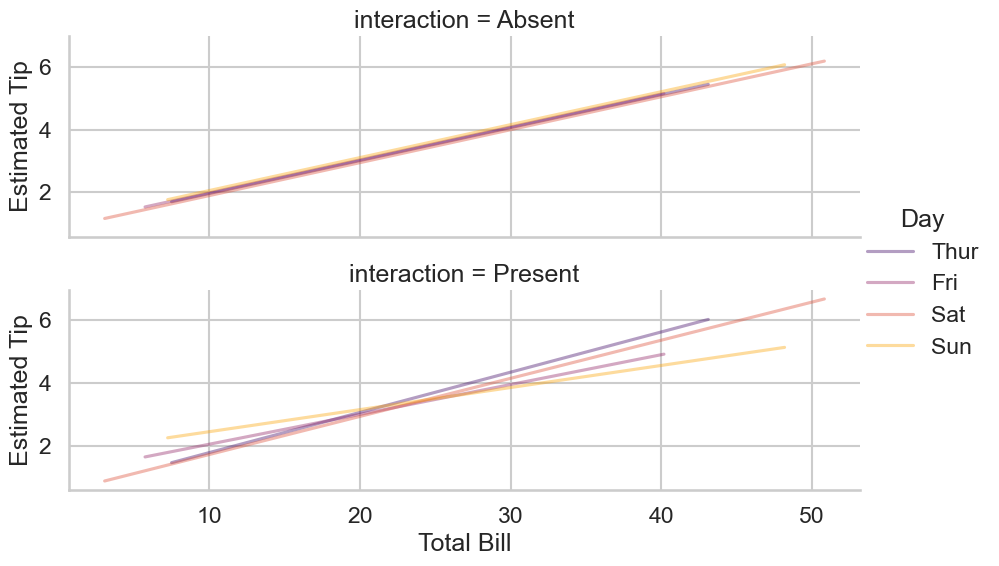

In [15]:
(sns.FacetGrid(data=predmat, row='interaction', aspect=3)
 .map_dataframe(sns.lineplot, x='total_bill', y='estimate', 
                hue='day', alpha=.4, palette='inferno')
 .add_legend(title='Day')
 .set_xlabels('Total Bill')
 .set_ylabels('Estimated Tip'))

Ultimately, the rationale about whether you include an interaction should be more about a) whether it makes sense in the context of answering the question, and b) whether you have enough data to estimate it, a problem that we will return to.